In [1]:
from IPython.display import set_matplotlib_formats, display
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_moons, make_blobs
from itertools import combinations

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "autumn_r"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['figure.facecolor'] = '#d3d3d3'
plt.rcParams['figure.autolayout'] = 'False'

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 15)
pd.set_option('precision', 2)

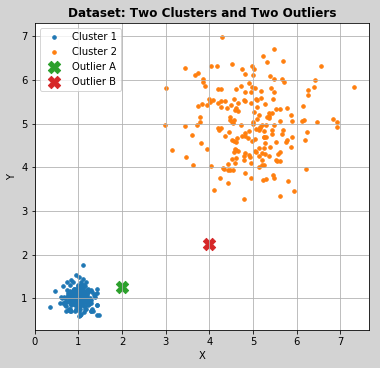

In [49]:
'''Define Parameters for Dataset'''
n_samples = 400
pct_outliers = 10
n_outliers = int(n_samples*pct_outliers/100)

def build_dataset(n_points):
    '''Builds data set with two outliers'''
    # build 2 center blobs
    blobs_params = dict(random_state=42, n_samples=n_points - 2, n_features=2)
    centers = [[1,1],[5,5]]
    p = np.zeros((n_points,2))
    l = np.zeros(n_points)
    deviations = [0.2,.75]
    p[:n_points-2,:],l[:n_points-2] = make_blobs(centers=centers,
                                                 cluster_std=deviations,**blobs_params)
    # Add in Outliers
    p[n_points-2:,:] = [[2,1.25],[4,2.25]]
    l[n_points-2:] = [2,3]
    return p,l


pnts, lbls = build_dataset(n_samples)
f = plt.figure(figsize = (6,6),facecolor='#d3d3d3')
ax = f.add_subplot(111, aspect=1)
lbl = ['Cluster 1','Cluster 2','Outlier A','Outlier B']
marker = ['.','.','X','X']
size = [50,50,150,150]
for i in range(len(lbl)):
    data = pnts[lbls == i]
    ax.scatter(data[:,0],data[:,1],s = size[i],
                marker = marker[i],label=lbl[i])
ax.set_title('Dataset: Two Clusters and Two Outliers',
         fontweight='bold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc='best')

_ = ax.grid(True)

#### Model Developement
##### Basic Idea: Compare local density of a point with densities of its neighbors. Outliers will have a lower density than other points. [2]
For a given data point, $\overline{X}$, let $D_k\big(\overline{X} \big)$ be its distance to the $k$-nearest neighbor. Let $L_k\big( \overline{X} \big)$ be the set of points with $k$-nearest neighbor distance of $\overline{X}$.

Then, **Reachability Distance**, $R_k \big(\overline{X},\overline{Y} \big)$, of object $\overline{X}$ with respect to $\overline{Y}$ is defined as the greater of the distance between $\overline{X}$ and $\overline{Y}$, $dist\big(\overline{X},\overline{Y} \big)$, and the $k$-nearest neighbor distance of $\overline{Y}$.
So,
\begin{equation}
R_k \big(\overline{X},\overline{Y} \big) = max \Big[dist\big( \overline{X},\overline{Y} \big), D_k\big(\overline{Y} \big) \Big]
\end{equation}

Now we define **Average Reachability Distance**, $AR_k \big(\overline{X}\big)$, of datapoint $\overline{X}$ with respect to its neighborhood, $L_k \big( \overline{X} \big)$, to be the average of its reachablility distances to all objects in its neighborhood.
Or,
\begin{equation}
AR_k \big(\overline{X}\big) = MEAN_{\overline{Y} \in L_k \big(\overline{X} \big)} \Big[ R_k \big(\overline{X},\overline{Y} \big) \Big]
\end{equation}

Finally, we define **Local Outlier Factor**, $LOF_k \big( \overline{X} \big)$, to simply be the mean ratio of $AR_k \big( \overline{X} \big)$ to the corresponding values of all points in the $k$-neighborhood of $\overline{X}$.

\begin{equation}
\boxed{LOF_k \big( \overline{X} \big) = MEAN_{\overline{Y} \in L_k \big( \overline{X} \big)} \Big[ \frac{AR_k \big( \overline{X} \big)}{AR_k \big( \overline{Y} \big)} \Big]}
\end{equation}

\begin{equation}
LOF_k \big( \overline{X} \big) \approx 1 \text{, Inlier}\\
LOF_k \big( \overline{X} \big) > 1 \text{, Outlier}
\end{equation}


## Example Case Algorithm

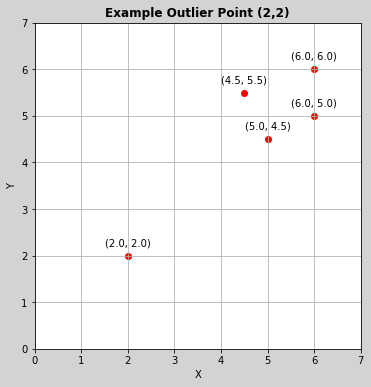

In [3]:
# Annotate Points for Aid in Illustraion
def mark_points(data_,ax_):
    for x,y in data_:
        label = "({:.1f}, {:.1f})".format(x,y)
        # this method is called for each point
        ax_.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

# Make Dummy Data
data = np.array([[2,2],[4.5, 5.5],[6,5],[5,4.5],[6,6]])

# Plot Data
f = plt.figure(figsize = (7,6),facecolor='#d3d3d3')
ax = f.add_subplot(111, aspect='equal')
ax.scatter(data[:,0],data[:,1],color = 'r')
mark_points(data,ax)
ax.set_ylim((0,7))
ax.set_xlim((0,7))
ax.grid(True)
ax.set_title('Example Outlier Point (2,2)',
            fontweight='bold')
ax.set_ylabel('Y')
_ = ax.set_xlabel("X")

In [4]:
k = 3 # number of nearest neighbors

dist = lambda X,Y: np.linalg.norm(X - Y) #L2 distance
def get_neighbors(df,k):
    n = df.shape[0]
    neighbors = []
    for row in df[range(n)].values:
        neighbors.append(np.argsort(row)[1:k+1])
    return neighbors

def dist_k_nearest(X,k):
    '''X a vector of distance to all neighbors and its self
    returns index of K and Distance'''
    k_nearest = np.argsort(X)[k]
    return k_nearest,X[k_nearest]

def get_Rk(df):
    Rk = []
    for i,kset in enumerate(df.Neighborhood):
        rk = []
        for n in kset:
            d = round(df.loc[i,n],3)
            dk = round(df['Dk'].loc[n],3)
            rk.append(max(d,dk))
        Rk.append(rk)
    return Rk

def get_LOF(df):
    LOFk = []
    for i, kset in enumerate(df.Neighborhood):
        lofk = []
        for n in kset:
            lofk.append(round(df['ARk'].loc[i]/df['ARk'].loc[n],4))
        LOFk.append(lofk)
    return LOFk

N = len(data)
d_matrix = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        d_matrix[i,j] = dist(data[i,:],data[j,:])
df = pd.DataFrame(d_matrix,columns = range(N))

# get distance to k-nearst neighbor
Dk_matrix = np.zeros((N,2))
for i,X in enumerate(d_matrix):
    Dk_matrix[i,:] = dist_k_nearest(X,k)

#Add Neighborgood, Distance to K nearest (Dk) and Index of K nearest To DataFrame
df['(x, y)'] = [row for row in data]
df['Neighborhood'] = get_neighbors(df,k)
df['K Nearest'] = Dk_matrix[:,0]
df['Dk'] = Dk_matrix[:,1]
df['Rk'] = get_Rk(df)
df['ARk'] = df['Rk'].apply(np.mean)
df['LOFk'] = get_LOF(df)
df['LOF'] = df['LOFk'].apply(np.mean)

display_cols = ['(x, y)','Neighborhood','K Nearest','ARk','LOF']
display(df)
display(df[display_cols])

,0,1,2,3,4,"(x, y)",Neighborhood,K Nearest,Dk,Rk,ARk,LOFk,LOF
0,0.00,4.30,5.00,3.91,5.66,"[2.0, 2.0]","[3, 1, 2]",2.0,5.00,"[3.905, 4.301, 5.0]",4.40,"[2.6598, 2.546, 2.546]",2.58
1,4.30,0.00,1.58,1.12,1.58,"[4.5, 5.5]","[3, 2, 4]",4.0,1.58,"[1.803, 1.581, 1.803]",1.73,"[1.0447, 1.0, 1.0447]",1.03
2,5.00,1.58,0.00,1.12,1.00,"[6.0, 5.0]","[4, 3, 1]",1.0,1.58,"[1.803, 1.803, 1.581]",1.73,"[1.0447, 1.0447, 1.0]",1.03
3,3.91,1.12,1.12,0.00,1.80,"[5.0, 4.5]","[1, 2, 4]",4.0,1.80,"[1.581, 1.581, 1.803]",1.66,"[0.9572, 0.9572, 1.0]",0.97
4,5.66,1.58,1.00,1.80,0.00,"[6.0, 6.0]","[2, 1, 3]",3.0,1.80,"[1.581, 1.581, 1.803]",1.66,"[0.9572, 0.9572, 1.0]",0.97


,"(x, y)",Neighborhood,K Nearest,ARk,LOF
0,"[2.0, 2.0]","[3, 1, 2]",2.0,4.40,2.58
1,"[4.5, 5.5]","[3, 2, 4]",4.0,1.73,1.03
2,"[6.0, 5.0]","[4, 3, 1]",1.0,1.73,1.03
3,"[5.0, 4.5]","[1, 2, 4]",4.0,1.66,0.97
4,"[6.0, 6.0]","[2, 1, 3]",3.0,1.66,0.97


## Small Scale Example with $k = 3$

Point $(2,2)$ has a neighbors $(5, 4.5 ), (4.5, 5.5), (5, 4.5)$ with euclidean distances from $(2,2)$ of $3.91, 4.3, 5.0$, respectively. So, $D_3 \big( (2,2) \big) = 5.0$ since $(5, 4.5)$ is the $3^{rd}$ nearest neighbor.

Calculating similarly for the other points shows they have $D_3$ of $1.80, 1.58, 1.58$, respectively.  

So, 
\begin{equation}
AR_3\big( (2,2) \big) = \frac{max(3.91,1.8) + max(4.3, 1.58) + max(5, 1.58)}{3} = \frac{3.91 + 4.3 + 5}{3} = 4.4
\end{equation}

Now, $(2,2)$'s neighbors have $AR_3$ of $1.66, 1.73, 1.73$ and this is used to calculate its **Local Outlier Factor** thusly,
\begin{equation}
LOF_3\big( (2,2) \big) = \frac{\frac{4.4}{1.66} + \frac{4.4}{1.73} + \frac{4.4}{1.73}}{3} = \frac{2.66 + 2.55 + 2.55}{3} = \boxed{2.58}
\end{equation}

This shows $(2,2)$ is an outlier since $2.58 > 1$.  Filling in the other points gives the following table. Notice that the other points in the dataset all are close to one another and have an $LOF_3 \approx 1$.

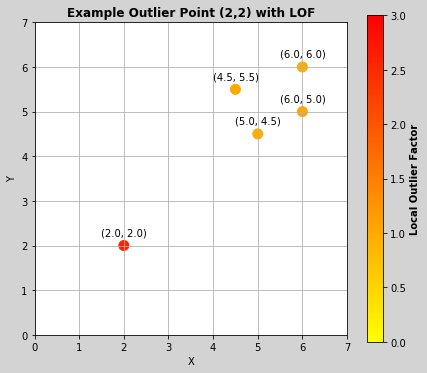

In [5]:
# Plot Data
f = plt.figure(figsize = (7,6),facecolor='#d3d3d3')
ax = f.add_subplot(111, aspect='equal')
sc = ax.scatter(data[:,0],data[:,1], s=100, c=df['LOF'],vmin=0,vmax=3)
mark_points(data,ax)
cbar= plt.colorbar(sc)
cbar.set_label("Local Outlier Factor",fontweight = 'bold')
ax.set_ylim((0,7))
ax.set_xlim((0,7))
ax.grid(True)
ax.set_title('Example Outlier Point (2,2) with LOF',
            fontweight='bold')
ax.set_ylabel('Y')
_ = ax.set_xlabel("X")


# Running on the Larger Dataset

Text(0.5, 1.0, 'SSE vs Clusters for KMeans')

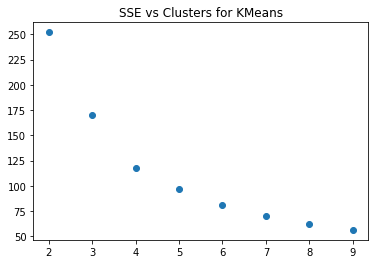

In [6]:
# Run Kmeans
sse_km = []
c_num = []
for i in range(2,10,1):
    km = KMeans(n_clusters=i,random_state=42).fit(pnts)
    c_num.append(i)
    sse_km.append(km.inertia_)
plt.plot(c_num,sse_km,'o')
plt.title('SSE vs Clusters for KMeans')


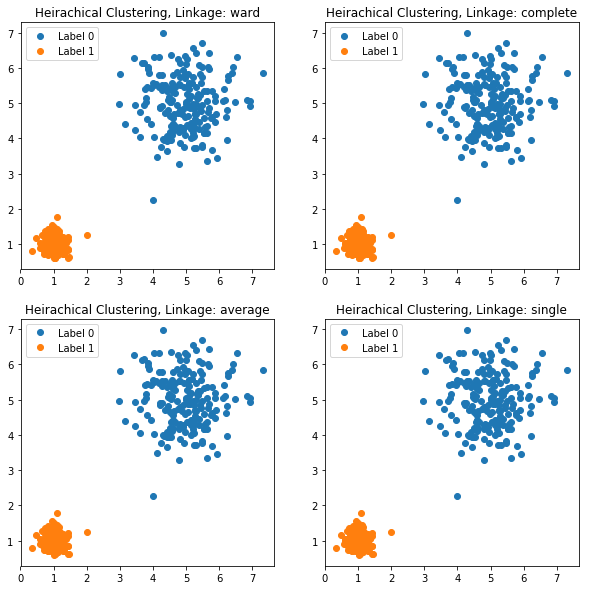

In [7]:
# Run Hierarchical Clustering
link = ['ward', 'complete', 'average', 'single']
f,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.set_title('Heirachical Clustering, Linkage: ' + link[i])
    hc = AgglomerativeClustering(linkage=link[i]).fit(pnts)
    for lbl in set(hc.labels_):
        flt = hc.labels_ == lbl
        ax.plot(pnts[flt,0],pnts[flt,1],'o',label='Label {:d}'.format(lbl))
    ax.legend(loc='best')

### Tuning LOF


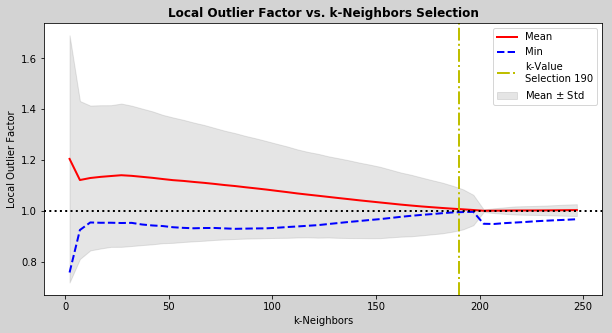

In [50]:
k_range = range(2,252,5)
results = np.zeros((len(k_range),5))
for i,k in enumerate(k_range):
    lof = LocalOutlierFactor(n_neighbors=k).fit(pnts)
    olf = -1*lof.negative_outlier_factor_
    results[i,:] = np.array([k,olf.min(),
                    olf.mean(),
                    olf.max(),
                    olf.std()])
tuning_df = pd.DataFrame(results,columns=['k','Min','Mean','Max','Std'])
tuning_df = tuning_df.set_index('k')

plt.figure(figsize=(10,5),facecolor='#d3d3d3')
plt.plot(tuning_df.index, tuning_df.Mean,'-r',label='Mean')
plt.plot(tuning_df.index, tuning_df.Min,'--b',label='Min')
plt.fill_between(tuning_df.index,tuning_df.Mean - tuning_df.Std,
                tuning_df.Mean + tuning_df.Std, alpha = 0.2, 
                color = 'tab:gray', label='Mean $\pm$ Std')
plt.axhline(1,ls=':',C='k')
kselect = 190
plt.axvline(kselect,ls='-.',C='y',
            label='k-Value\nSelection {:d}'.format(kselect))
plt.legend(loc='best')
plt.title('Local Outlier Factor vs. k-Neighbors Selection',
         fontweight='bold')
plt.ylabel('Local Outlier Factor')
_ = plt.xlabel('k-Neighbors')

C:\Users\josh.galloway\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


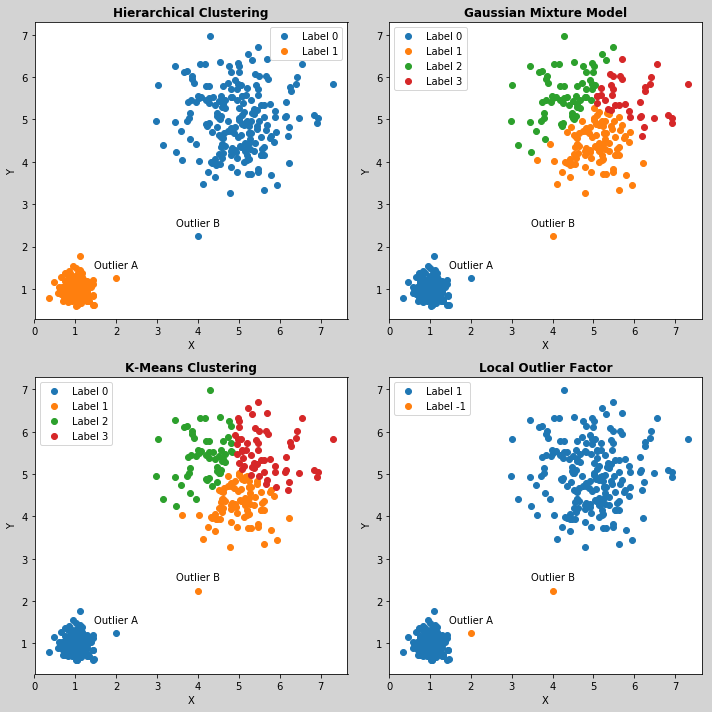

In [43]:
'''Plot LOF,  Kmeans and Hierarchical on Original Dataset'''
def label_outlier(point, label, ax_):
    x,y = point
    ax_.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


hc = AgglomerativeClustering().fit(pnts).labels_
km = KMeans(n_clusters = 4, random_state=42, n_init=10).fit(pnts).labels_
gmm = GaussianMixture(n_components=4).fit(pnts).predict(pnts)
lof = LocalOutlierFactor(n_neighbors=190).fit_predict(pnts)

f,axes = plt.subplots(nrows = 2, ncols= 2, figsize=(10,10),facecolor='#d3d3d3',
                     tight_layout = True)
axes = axes.ravel()
titles = ['Hierarchical Clustering', 'Gaussian Mixture Model',
          'K-Means Clustering', 'Local Outlier Factor']
models = [hc,gmm,km,lof]

for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontweight='bold')
    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    # label outliers
    label_outlier(pnts[-1,:],'Outlier B',ax)
    label_outlier(pnts[-2,:],'Outlier A',ax)
    for lbl in set(models[i]):
        flt = models[i] == lbl
        ax.plot(pnts[flt,0],pnts[flt,1],'o',label='Label {:d}'.format(lbl))
    ax.legend(loc='best')